# Importing the needed modules

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
# import seaborn as sns
from graphviz import Digraph
from graphviz import Graph
# import pydot
from pprint import pprint
import networkx as nx
import random

# Reading the datasets

In [16]:
trainData = pd.read_csv('../Datasets/sample_train.csv')
devData = pd.read_csv('../Datasets/sample_dev.csv')
testData = pd.read_csv('../Datasets/sample_test.csv')
dataFrame = pd.DataFrame(trainData)

In [ ]:
def data_init(file):
    trainData = pd.read_csv(file)
    dataFrame = pd.DataFrame(trainData)
    return dataFrame
#     dataFrame=dataFrame.drop("rating",axis=1)

In [19]:
def words_count(dataFrame):
    d = []
    if 'rating' in dataFrame.columns:
        d = dataFrame.rating
        dataFrame = dataFrame.drop('rating',axis=1)
    features = ['contains_No', 'contains_Please', 'contains_Thank', 'contains_apologize', 'contains_bad',
    'contains_clean', 'contains_comfortable', 'contains_dirty', 'contains_enjoyed', 'contains_friendly',
    'contains_glad', 'contains_good', 'contains_great', 'contains_happy', 'contains_hot', 'contains_issues',
    'contains_nice', 'contains_noise', 'contains_old', 'contains_poor', 'contains_right', 'contains_small', 
    'contains_smell', 'contains_sorry', 'contains_wonderful', 'reviews.text', 'count_reviews.text']
    
    for i in dataFrame.columns:
        c = i.replace('contains_','')
        col = []
        for j in range(0,dataFrame.shape[0]):
            if dataFrame[i][j]==1:
                col.append(dataFrame['reviews.text'][j].count(c))
            else:
                col.append(0)
        dataFrame['count_'+c]=col
    
    dataFrame = dataFrame.drop(features,axis=1)
    dataFrame = dataFrame.join(d)
    return dataFrame

In [20]:
def check_purity(data):
    
    rating_column = data[:, -1]
    unique_classes = np.unique(rating_column)

    if len(unique_classes) == 1:
        return True
    else:
        return False

In [49]:
def classify_data(data):
    
    rating_column = data[:, -1]
    unique_classes, counts_unique_classes = np.unique(rating_column, return_counts=True)

    index = counts_unique_classes.argmax()
    classification = unique_classes[index]
    
    return classification

In [22]:
def get_potential_splits(data):
    
    potential_splits = {}
    n_columns = data.shape[1]
    for column_index in range(n_columns - 1):        # excluding the last column which is the rating
        potential_splits[column_index] = []
        values = data[:, column_index]
        unique_values = np.unique(values)

        potential_splits[column_index]=unique_values
        
    return potential_splits

In [23]:
def split_data(data, split_column, split_value):
    
    split_column_values = data[:, split_column]

    data_below = data[split_column_values <= split_value]
    data_above = data[split_column_values > split_value]
    
    return data_below, data_above

In [24]:
def calculate_entropy(data):
    
    rating_column = data[:, -1]
    _, counts = np.unique(rating_column, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
     
    return entropy

In [25]:
def calculate_overall_entropy(data_below, data_above):
    
    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n

    overall_entropy =  (p_data_below * calculate_entropy(data_below) 
                      + p_data_above * calculate_entropy(data_above))
    
    return overall_entropy



In [26]:
def determine_best_split(data, potential_splits):
    
    overall_entropy = 9999
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            current_overall_entropy = calculate_overall_entropy(data_below, data_above)

            if current_overall_entropy <= overall_entropy:
                overall_entropy = current_overall_entropy
                best_split_column = column_index
                best_split_value = value
    
    return best_split_column, best_split_value




In [110]:
def decision_tree_algorithm(df, counter=0, min_samples=2, max_depth=5):
    
    # data preparations
    if counter == 0:
        global COLUMN_HEADERS
        COLUMN_HEADERS = df.columns
        data = df.values
    else:
        data = df           
    
    
    # base cases
    if (check_purity(data)) or (len(data) < min_samples) or (counter == max_depth):
        classification = classify_data(data)
        
        return classification

    
    # recursive part
    else:    
        counter += 1

        # helper functions 
        potential_splits = get_potential_splits(data)
        split_column, split_value = determine_best_split(data, potential_splits)
        data_below, data_above = split_data(data, split_column, split_value)
        
        if len(data_below)==0 or len(data_above)==0:    
            classification = classify_data(data)
            return classification
            
        
        # instantiate sub-tree --to be converted into nodes
        feature_name = COLUMN_HEADERS[split_column]
        question = "{} = {}".format(feature_name, split_value)
        sub_tree = {question: []}
    
        yes_answer = decision_tree_algorithm(data_below, counter, min_samples, max_depth)
        no_answer = decision_tree_algorithm(data_above, counter, min_samples, max_depth)

        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
            
        
        
        return sub_tree
    

In [111]:
def classify_example(example, tree):
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split()

    # ask question
    if str(example[feature_name]) <= value:
        
        answer = tree[question][0]
    else:
        answer = tree[question][1]

    # base case
    if not isinstance(answer, dict):
        return answer
    
    # recursive part
    else:
        residual_tree = answer
        return classify_example(example, residual_tree)

In [112]:
def predict(df,tree):
    df=words_count(df)
    df["classification"] = df.apply(classify_example, axis=1, args=(tree,))
    with open('output.txt', 'w') as f:
        for text in df['classification'].tolist():
            f.write(text + '\n')
    return df['classification'].values
    

In [113]:
def calculate_accuracy(df_, tree,show=False):
    df=words_count(df_)
    df["classification"] = df.apply(classify_example, axis=1, args=(tree,))
    df["classification_correct"] = df["classification"] == df["rating"]
    
    accuracy = df["classification_correct"].mean()
    if show==True:
        #print(df.classification)
        #print(df.classification_correct)
#         print(df[['classification'],['classification_correct']])
        print(df[['classification', 'classification_correct']])
    return accuracy

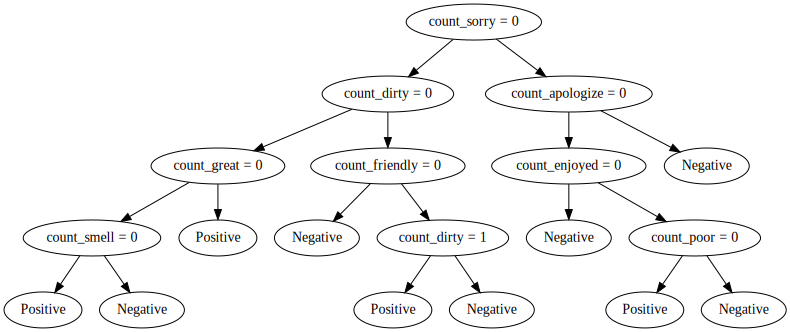

In [118]:
s = words_count(dataFrame)
t = decision_tree_algorithm(s, max_depth=4)
x=calculate_accuracy(devData,t)
d=Digraph()
draw_graph(t)
#x = predict(words_count(c),t)
d

In [117]:
t

{'count_sorry = 0': [{'count_dirty = 0': ['Positive',
    {'count_friendly = 0': ['Negative', 'Positive']}]},
  {'count_apologize = 0': [{'count_enjoyed = 0': ['Negative', 'Positive']},
    'Negative']}]}

# Implementing Node and Tree Classes

In [57]:
class Node:
    def __init__(self,key):
        self.val = key
        self.left = None
        self.right = None
    def set_val(self,_val):
        self.val=_val
    def get_val(self):
        return self.val
    def set_left(self,_left):
        self.left=_left
    def get_left(self):
        return self.left
    def set_right(self,_right):
        self.right=_right
    def get_right(self):
        return self.right
    
    
    
        

In [80]:
class Tree:
    def __init__(self, _val = None):
        self.root = Node(_val)
        self.right, self.left = None, None
    def insert_right(self,right_node):
        if not isinstance(right_node, Tree):
            self.root.right=right_node
        else:
            self.root.right=right_node.root
            
    def insert_left(self,left_node):
        if not isinstance(left_node, Tree):
            self.root.left=left_node
        else:
            self.root.left=left_node.root     
    
        

In [ ]:
def todict(root):
        dctionary ={root.val:[]}
        if root.left==root.right==None:
            dictionary=root.val
        else:
            dictionary[]
        
        
        return

In [120]:
def decision_tree_algorithm(df, counter=0, min_samples=2, max_depth=5):
    
    # data preparations
    if counter == 0:
        global COLUMN_HEADERS
        COLUMN_HEADERS = df.columns
        data = df.values
    else:
        data = df           
    
    
    # base cases
    if (check_purity(data)) or (len(data) < min_samples) or (counter == max_depth):
        classification = classify_data(data)
        
        return Node(classification)

    
    # recursive part
    else:    
        counter += 1
        # helper functions 
        potential_splits = get_potential_splits(data)
        split_column, split_value = determine_best_split(data, potential_splits)
        data_below, data_above = split_data(data, split_column, split_value)
        
        if len(data_below)==0 or len(data_above)==0:    
            classification = classify_data(data)
            return Node(classification)
            
        
        # instantiate sub-tree --to be converted into nodes
        feature_name = COLUMN_HEADERS[split_column]
        question = "{} = {}".format(feature_name, split_value)
        sub_tree = Tree(question)
    
        yes_answer= decision_tree_algorithm(data_below, counter, min_samples, max_depth)
        no_answer = decision_tree_algorithm(data_above, counter, min_samples, max_depth)

        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree.insert_left(yes_answer)
            sub_tree.insert_right(no_answer)
        return sub_tree
    

In [121]:
def classify_example(example, root):
    question = root.val
    feature_name, comparison_operator, value = question.split()

    # ask question
    if str(example[feature_name]) <= value:
        answer = root.left
    else:
        answer = root.right

    # base case
    if answer.left==answer.right==None:  
        return answer.val
    
    # recursive part
    else:
        residual_root = answer
        return classify_example(example, residual_root)

In [122]:
def calculate_accuracy(df_, tree,show=False):
    df=words_count(df_)
    df["classification"] = df.apply(classify_example, axis=1, args=(tree.root,))
    df["classification_correct"] = df["classification"] == df["rating"]
    
    accuracy = df["classification_correct"].mean()
    if show==True:
        #print(df.classification)
        #print(df.classification_correct)
#         print(df[['classification'],['classification_correct']])
        print(df[['classification', 'classification_correct']])
    return accuracy

In [123]:
def draw_graph(root):
    global d
    question = root.val
    feature_name,_,value = question.split()
    d.node(feature_name+value,question)
    
    answer_yes  = root.left
    answer_no = root.right
    
    if answer_yes.left==answer_yes.right==None:
        d.node(feature_name+value+answer_yes.val,answer_yes.val)
        d.edge(feature_name+value,feature_name+value+answer_yes.val)
    else:
        answer_question_yes = answer_yes.val
        feature_name_yes,_,value_yes = answer_question_yes.split()
        d.node(feature_name_yes+value_yes,feature_name_yes)
        d.edge(feature_name+value,feature_name_yes+value_yes)
        draw_graph(answer_yes)
   
    if answer_no.left==answer_no.right==None:
        d.node(feature_name+value+answer_no.val,answer_no.val)
        d.edge(feature_name+value,feature_name+value+answer_no.val)
    else:
        answer_question_no = answer_no.val
        feature_name_no,_,value_no = answer_question_no.split()
        d.node(feature_name_no+value_no,feature_name_no)
        d.edge(feature_name+value,feature_name_no+value_no)
        draw_graph(answer_no)
    return
        
    
        

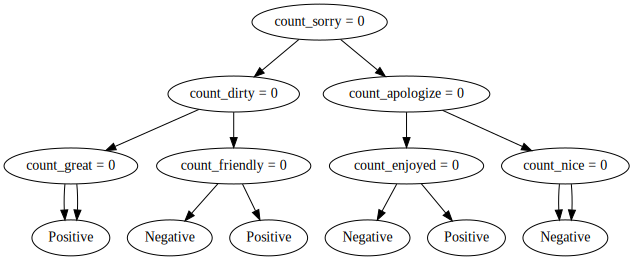

In [124]:
# c = trainData
s = words_count(dataFrame)
t = decision_tree_algorithm(s, max_depth=3)
#x=calculate_accuracy(devData,t)
#x = predict(words_count(c),t)
d = Digraph(format='png')
draw_graph(t.root)
d
#d.render()



# Drawing the trained tree

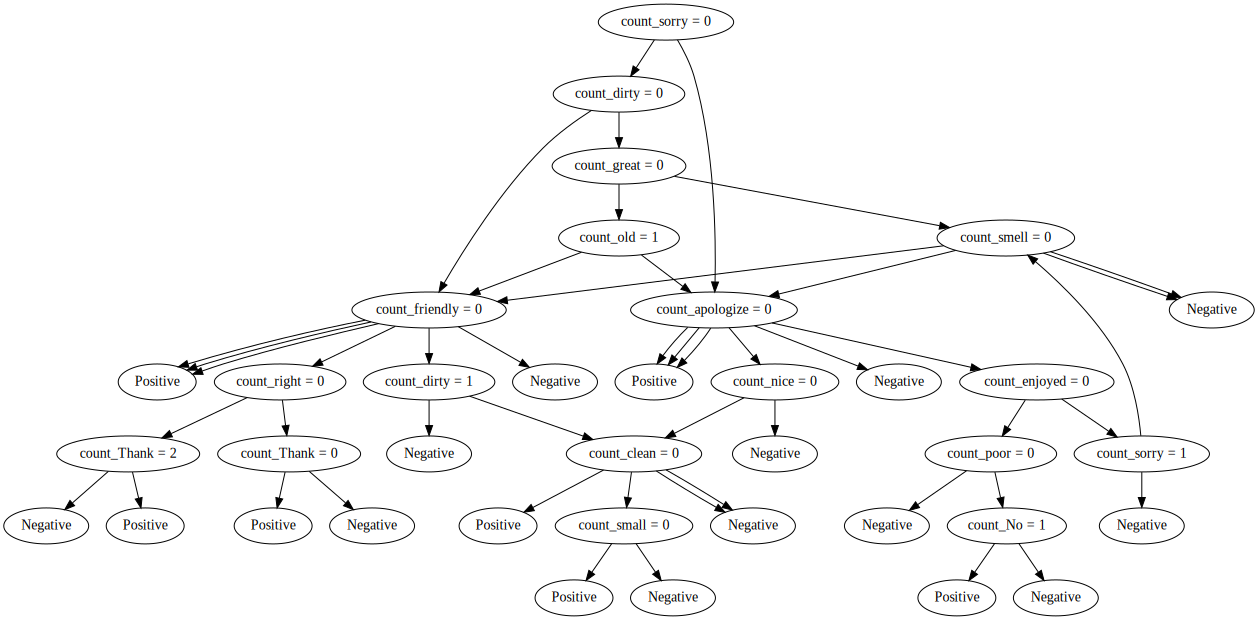

In [104]:
d

In [114]:
def draw_graph(tree):
    global d
    question = list(tree.keys())[0]
    feature_name,_,value = question.split()
    d.node(feature_name+value,question)
    
    answer_yes  = tree[question][0]
   
    answer_no = tree[question][1]
    
    if not isinstance(answer_yes, dict):
        d.node(feature_name+value+answer_yes,answer_yes)
        d.edge(feature_name+value,feature_name+value+answer_yes)
    else:
        answer_question_yes = list(answer_yes.keys())[0]
        feature_name_yes,_,value_yes = answer_question_yes.split()
        d.node(feature_name_yes+value_yes,feature_name_yes)
        d.edge(feature_name+value,feature_name_yes+value_yes)
        draw_graph(answer_yes)
   
    if not isinstance(answer_no, dict):
        d.node(feature_name+value+answer_no,answer_no)
        d.edge(feature_name+value,feature_name+value+answer_no)
    else:
        answer_question_no = list(answer_no.keys())[0]
        feature_name_no,_,value_no = answer_question_no.split()
        d.node(feature_name_no+value_no,feature_name_no)
        d.edge(feature_name+value,feature_name_no+value_no)
        draw_graph(answer_no)
    return
        
    
        
    
        
    
    #answer_yes  = list(tree[question][0].keys())[0]
    #answer_node = list(tree[question][1].keys())[0]
    
    
    

In [34]:
def draw_graph2(tree,count=0):
    global d
    question = list(tree.keys())[0]
    feature_name,_,value = question.split()
    d.node(feature_name+str(count),question)
    
    answer_yes  = tree[question][0]
   
    answer_no = tree[question][1]
    
    if not isinstance(answer_yes, dict):
        d.node(feature_name+str(count)+answer_yes,answer_yes)
        d.edge(feature_name+str(count),feature_name+str(count)+answer_yes)
    else:
        answer_question_yes = list(answer_yes.keys())[0]
        feature_name_yes,_,_ = answer_question_yes.split()
        d.node(feature_name_yes+str(count),answer_question_yes)
        d.edge(feature_name+str(count),feature_name_yes+str(count))
        draw_graph2(answer_yes,count+1)
   
    if not isinstance(answer_no, dict):
        d.node(feature_name+str(count)+answer_no,answer_no)
        d.edge(feature_name+str(count),feature_name+str(count)+answer_no)
    else:
        answer_question_no = list(answer_no.keys())[0]
        feature_name_no,_,_ = answer_question_no.split()
        d.node(feature_name_no+str(count),answer_question_no)
        d.edge(feature_name+str(count),feature_name_no+str(count))
        draw_graph2(answer_no,count+1)
    return
        
            
    
    #answer_yes  = list(tree[question][0].keys())[0]
    #answer_node = list(tree[question][1].keys())[0]
    
    

In [87]:
s = words_count(dataFrame)
t = decision_tree_algorithm(s, max_depth=5)
# d = Digraph(format='png')
# draw_graph(t)
# d.render()



In [88]:
t